# Demo básica de um RAG

Aqui vou usar o elasticsearch como vector database. E OpenAI como LLM. 

## Arquitetura da busca semântica

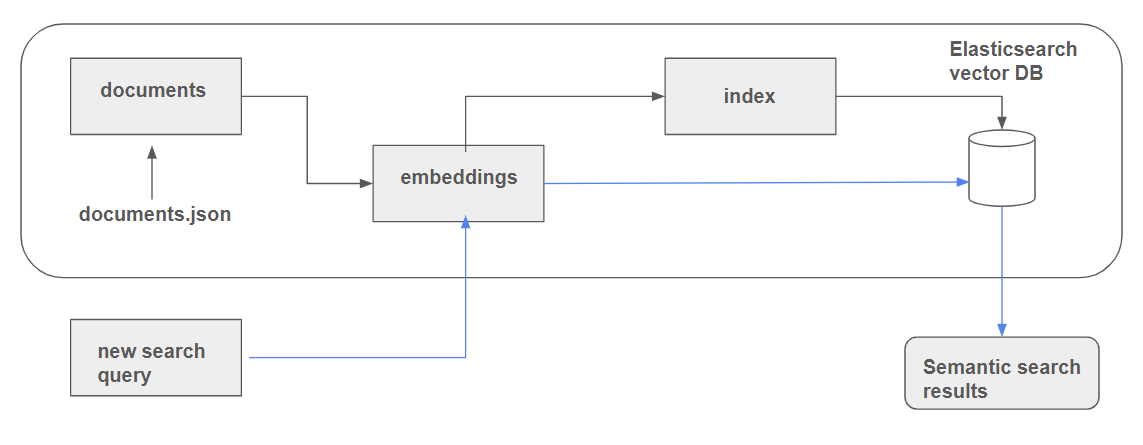

Aqui, a gente tem basicamente um workflow básico do elasticsearch, com a diferença de que vamos usar um modelo pronto de machine learning pra transformar nossos dados em vetores (aqueles do ensino médio que víamos em geometria analítica e algebra linear).
E só depois disso que vamos salvar no elastic

# Criando um sistema básico de busca semântica. 
Nesse exemplo vou usar como fonte de dados o arquivo `documents.json` que está no projeto, que é basicamente um FAQ extraído de 300 páginas de excel de vários cursos do Data Talks Club. São cursos gratuitos e bem interessantes.

## Passo 1: Preparar os documentos

In [4]:
import json
from dataclasses import dataclass
with open('documents.json', 'rt') as file:
    docs_raw = json.load(file)

# Os documentos estão numa estrutura agrupada, e eu quero transformar isso tudo numa listona de documentos

# A estrutura final desejada é isso aqui
@dataclass
class Doc:
    text: str
    section: str
    question: str
    course: str

documents: list[Doc] = []

for course_dict in docs_raw:
    for doc in course_dict['documents']:
        doc['course'] = course_dict['course']
        documents.append(doc)

    
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

## Passo 2: Criar os embeddings

Aqui vou usar a biblioteca `sentence_transformes` pra criar o embbeding do texto. Cada tipo de arquivo tem seu próprio modelo que podemos usar pra transformar os dados em um monte de vetores.

Se você instalou o requirements.txt, já está instalado. Se não, é só rodar

```bash
pip install sentence_transformers
```

Em termos de espaço esse pacote é bem pesadinho porque tem o pytorch como dependência. 

Pytorch é uma lib de treinamento de modelos, feita pelo Facebook. E, ao que parece, tomou o mundo acadêmico e todo mundo está deixando o tensorflow de lado pra usar o pytorch nas pesquisas de ponta. Todos os papers e projetos sobre transformers que vi, só usavam pytorch.

A ideia de usar vetores pra fazer busca semântica é bem simples:
1. Você transforma seus dados em vetores pra conseguir fazer manipulações matemáticas de forma mais fácil
2. Vetores com semântica (significados) parecidos vão tender a ter valores parecidos.
3. Na hora de buscar, seu texto também é convertido em vetores.
4. Daí basta aplicar a boa e velha similaridade dos cossenos, pra achar vetores parecidos com os da sua busca. Então eu não quero um match exato do texto, e sim achar vetores que são similares aos meus. Isso é muito mais fácil de fazer com matemática usando uma representação "numérica", do que programar algo do tipo e trabalhar somente com texto.
[Esse artigo](https://dev.to/josethz00/vector-databases-5df1) pode explicar mais detalhadamente isso

E aqui está a [Documentação](https://sbert.net/docs/sentence_transformer/pretrained_models.html) da lib que vamos usar

In [2]:
from sentence_transformers import SentenceTransformer

# Só estou escolhendo qual modelo usar, na documentação tem as opções
# Link desse modelo no hugginface https://huggingface.co/sentence-transformers/all-mpnet-base-v2
model = SentenceTransformer('all-mpnet-base-v2')

/home/marcus/Projects/courses/llm-zoomcamp/demo_rag_elastic/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [32]:
# Aqui ele vai fazer o output de uma vetor denso (dense vector) com uma porrada de números. 
# Essa é a representação numérica dos nossos dados. Muito mais fácil de manipular algebricamente 
# do que esse monte de letras que lemos.
print(model.encode('Olá, isso é uma sentença simples'))

[-3.38631421e-02 -4.85308953e-02  5.14770113e-03  1.04941642e-02
  4.86248359e-02 -3.20173204e-02 -3.91465873e-02  7.35467151e-02
  8.52995832e-03 -3.71058248e-02 -2.64083054e-02  7.19850138e-03
  1.52386306e-02 -3.98785956e-02 -3.12346928e-02 -1.70603748e-02
 -4.89282161e-02  3.33225466e-02 -5.25829010e-02 -3.40169892e-02
  4.33153764e-04 -2.54468378e-02  8.51113629e-03  7.74367712e-03
  1.13113321e-01 -2.38629524e-02  1.44378059e-02 -3.14793959e-02
 -6.45884424e-02  3.64722349e-02 -3.04086506e-02 -3.11296638e-02
  1.22144446e-02 -4.60449010e-02  1.89945786e-06 -2.54058577e-02
 -3.49212289e-02 -3.80708054e-02 -1.94315575e-02 -6.13696799e-02
  1.46763558e-02  3.73541825e-02 -1.47121791e-02 -1.43454631e-03
 -3.42235081e-02  3.61293368e-02  3.34399678e-02 -8.98056403e-02
  2.40199897e-03  8.34719911e-02 -2.22390424e-03 -3.32597308e-02
 -9.28260293e-03  1.99351599e-03  2.66635623e-02  6.19092537e-03
 -1.24442177e-02 -1.15009189e-01 -5.11652082e-02  5.69078326e-02
  1.24039073e-02 -4.17333

In [5]:
# Agora vamos criar os embeddings (nesse caso, transformar nossos objetos em vetores)
# Nesse exemplo simples, eu vou criar um embedding só pro campo `text` do meu documento
# E eu vou salvar o vetor dentro do meu proprio documento que foi vetorizado.
# Então eu tenho tanto o meu texto original, quanto a sua representação como vetor no documento

# Pode demorar uns minutinhos pra gerar os embeddings de todos os 1000 documentos
# operations = []
for doc in documents:
    doc['vector_text'] = model.encode(doc['text']).tolist()
    # Isso aqui é só pra ficar mais fácil de montar a query pra injetar os dados no elastic
    # operations.append(doc)


In [6]:
# E aqui podemos ver que os embeddings foram criados com sucesso
print(documents[0])

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'vector_text': [-0.03570348396897316,
  -0.0689142569899559,
  -0.044483356177806854,
  0.006250121630728245,
  -0.04224712401628494,
  -0.006453992798924446,
  0.02754809893667698,
  -0.018610363826155663,
  -0.05203752964735031,
  -0.0024046506732702255,
  0.05745451897382736,
  -0.015592561103403568,
  0.015488876961171627,
  0.09870164841413498,
  0.01564965583384037,
  -0.0

## Passo 3: Conectando no Elasticsearch
Essa parte é molezinha, só lembrar de rodar

```bash
docker compose up -d
```
e esperar um pouco pro container do elasticsearch subir.

In [10]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch("http://localhost:9200")

# Verificando se conectou certinho
print(es_client.info())

ObjectApiResponse({'name': '46129d22cc35', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'sJYJXjoMRVeWu1atZREDOQ', 'version': {'number': '8.11.4', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'da06c53fd49b7e676ccf8a32d6655c5155c16d81', 'build_date': '2024-01-08T10:05:08.438562403Z', 'build_snapshot': False, 'lucene_version': '9.8.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

## Passo 4: Criando um índice no Elastic pra salvar nossos dados

* O índice é como uma tabela num banco de dados relacional
* O `mapping` define o formato dos documentos salvos nesse índice
* Cada documento é como se fosse uma "row" nessa nossa "tabela"
* O nosso campo de `embedding` que será usado na busca semântica é do tipo `dense_vector`


In [12]:
index_conf = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": { "type": "text" },
            "question": { "type": "text" },
            "section": { "type": "text" },
            "course": { "type": "keyword" },
            "vector_text": { "type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"}
        }
    }
}

# Aqui eu defini que meu vetor tem 768 dimensões (varia de modelo pra modelo), e defini que vou usar
# "similaridade de cossenos" pro algoritmo que vai determinar a similaridade da minha query com meus documentos

index_name = 'course_questions'

# Aqui eu só deleto o índice a cada vez que rodar esse código pra sempre conseguir criar um indice válido
es_client.indices.delete(index=index_name, ignore_unavailable=True)

es_client.indices.create(index=index_name, body=index_conf)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course_questions'})

## Passo 5: Indexando os documentos

In [14]:
# Aqui eu poderia usar a BulkAPI do elastic, mas eu estou com preguiça de lidar com NDJson
# então vamos usar um for loop mesmo

for doc in documents:
    try: 
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(f'deu pau no documento {doc["question"]}')
        print(e)


## Passo 6: Montando a busca do usuário
Aqui primeiro nós vamos: 
1. pegar a sentença buscada pelo usuário
2. Converter pra um vetor, usando o mesmo modelo que usamos pra fazer o embedding de todos os documentos
3. Buscar por esse valor no campo `vector_text` lá no indice do elastic

In [31]:
# Estamos no contexto de um curso de tecnologia, a pesquisa precisa ser algo relacionado a isso né
search_term = "Can I use mac or windows?"
vector_search_term = model.encode(search_term)

query = {
    "field": "vector_text",
    "query_vector": vector_search_term,
    "k": 5, # Significa que quero pegar o Top 5 documentos mais próximos da busca
    "num_candidates": 10000, # Meio que a quantidade maxima de documentos que olhar?
}

# Esse array no source é só pra ele me retornar todos os campos, menos o `vector_text` que é um vetorzão de numeros
# que eu não preciso mostrar pro usuário
res = es_client.search(index=index_name, knn=query, source=["course","question", "text"])
print(json.dumps(res.body, indent=2))


{
  "took": 26,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 5,
      "relation": "eq"
    },
    "max_score": 0.74336237,
    "hits": [
      {
        "_index": "course_questions",
        "_id": "YZZV6ZEBbpBku6fKlfZw",
        "_score": 0.74336237,
        "_source": {
          "text": "Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully",
          "question": "Environment - Is the course [Windows/mac/Linux/...] friendly?",
          "course": "data-engineering-zoomcamp"
        }
      },
      {
        "_index": "course_questions",
        "_id": "VZZV6ZEBbpBku6fKlPbg",
        "_score": 0.641734,
        "_source": {
          "text": "Choose the approach that aligns the most with your idea for the end project\nOne of those should suffice. However, BigQuery, which is part of GCP, will be used, so learning that is pr

Veja que o primeiro resultado está falando que os 3 sistemas operacionais são bons pro curso. Ou seja, o elastic conseguiu achar uma resposta satisfatória pro usuário, mesmo que o documento desejado não tenha nenhuma menção às palavras "mac" ou "windows" no campo `text` que representa a resposta do nosso FAQ. 

Tudo isso foi possível usando busca semântica com vetores e algebra linear 😎